<a href="https://colab.research.google.com/github/wengangmao/vattenfall/blob/main/Keras_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# plt.style.use(['science','no-latex'])
# plt.rcParams["font.family"] = "Times New Roman"
%load_ext autoreload
%autoreload 2

import tensorflow as tf

## 1, Load the data

In [2]:
from tensorflow import keras
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/Data/vattenfall_turbine.csv')
#drive.flush_and_unmount()
#print('NB: Unmount the google cloud driver')

#import numpy as np
#
##df = pd.read_csv('vattenfall_turbine.csv')
#keys = df.keys().values
#feature_keys = keys[np.arange(1,5).tolist() + np.arange(7,10).tolist()]
#time_key = keys[0]

In [3]:
################# IN case not by Colab #########
import numpy as np

df = pd.read_csv(r'E:\FEM\Python\bitbucket\Vattenfall_rnn\vattenfall_turbine.csv')
keys = df.keys().values
feature_keys = keys[np.arange(1,5).tolist() + np.arange(7,10).tolist()]
time_key = keys[0]

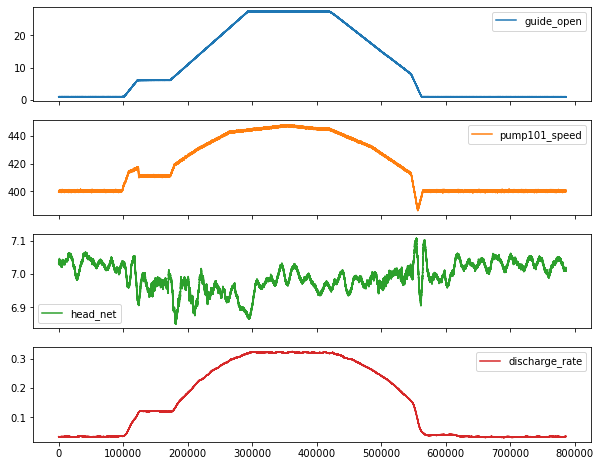

<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>

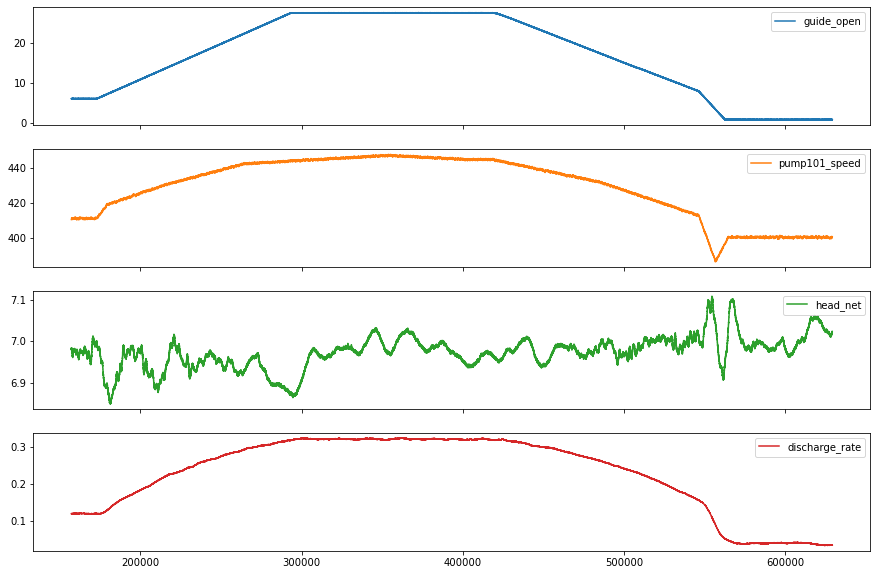

In [4]:
plot_cols = feature_keys[0:len(feature_keys):2]
plot_features = df[plot_cols]
#plot_features.index = df[time_key]
fig1 = plot_features.plot(subplots=True, figsize=(10, 8))
plt.show()

from IPython.display import display, Markdown
#display(Markdown(' <font size="6"><span style="color:blue">**Lets take a close look at the time series.**</span> </font>'))

display(Markdown('<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>'))

plot_features = df[plot_cols][int(len(df)/5):int(len(df)*4/5):10]
#plot_features.index = df[time_key][:480]
fig2 = plot_features.plot(subplots=True, figsize=(15, 10))

## 2, Preprocessing data: normalize, train, validation, test, etc.

### 2.1, resample the data with low-resolution

<span style="color:red; font-size:30px">**No. of the values in the training dataset is: 47186**</span>

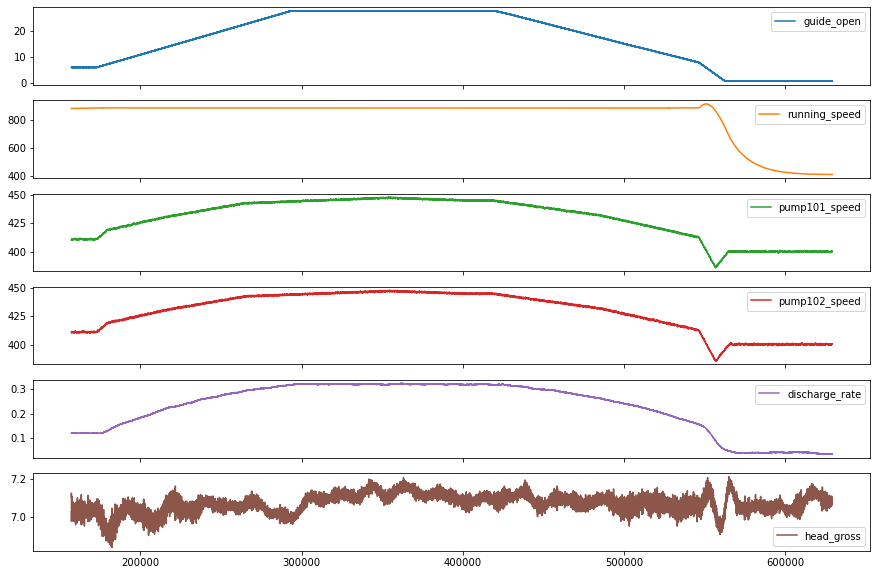

<span style="color:blue; font-size:20px">**Plot the heatmap for variation of standard deviation**</span>

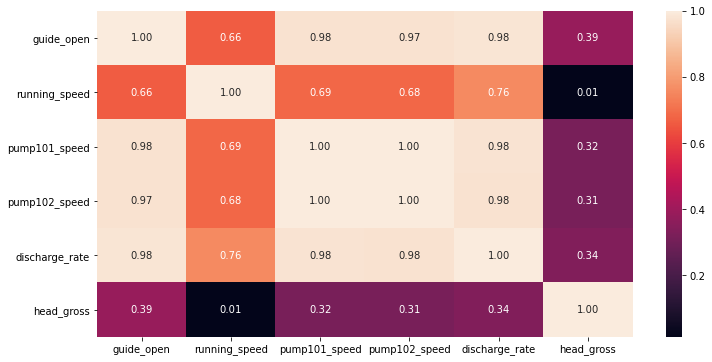

In [5]:
df_train = df[feature_keys[[0, 1, 2, 3]+[6]+[5]]][int(len(df)*0.2):int(len(df)*0.8):10]
display(Markdown('<span style="color:red; font-size:30px">**No. of the values in the training dataset is: %d**</span>' %len(df_train)))

# plot the data and check their variations along time
df_train.plot(subplots=True, figsize=(15, 10))
plt.show()
#print('No. of the values in the training dataset is: %d' %len(df_train))

display(Markdown('<span style="color:blue; font-size:20px">**Plot the heatmap for variation of standard deviation**</span>'))
# check he correlation
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f")
plt.show()

### 2.2, normalize the data

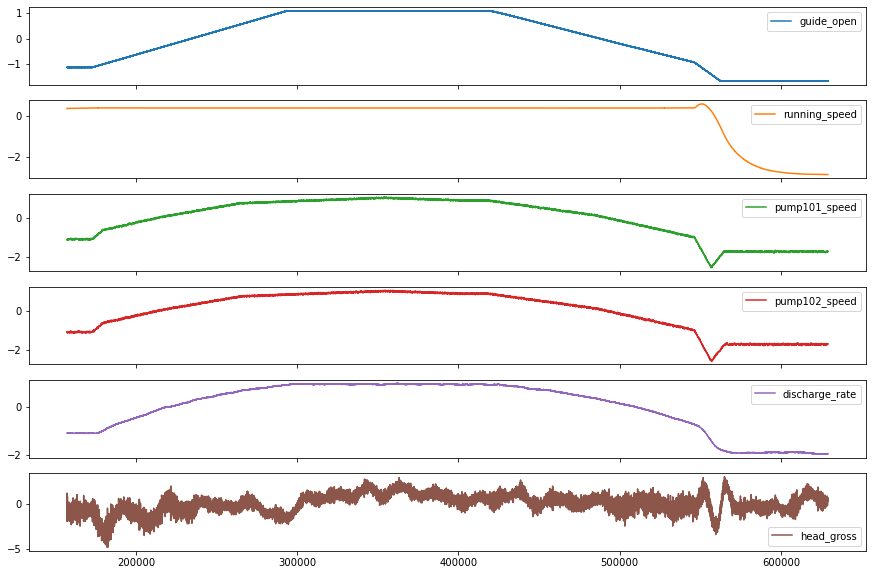

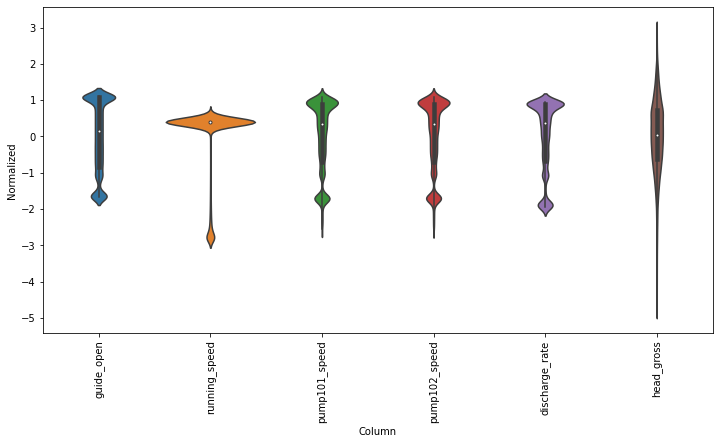

In [6]:
# First, we assume all data are used for the training (the time series is not that stationary for the prediction)
df_train_mean = df_train.mean()
df_train_std = df_train.std()
train_df = (df_train-df_train_mean) / df_train_std

fig2 = train_df.plot(subplots=True,figsize=(15,10))

# Second, plot the standand deviation of features within this dataframe
df_std = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
fig3 = ax.set_xticklabels(train_df.keys(), rotation=90)

## <font color ='blue'> **2021-11-05:**</font> Test the functions of the tf.data.Dataset for slice data to formulate rolling windowed dataset

In [42]:
df_train = df_train.reset_index(drop=True)

split_fraction = 0.8
train_split = int(df_train.shape[0]*split_fraction)
past = 100
future = 10
step = 10
learning_rate = 0.01
batch_size = 50
epochs = 10


train_data = df_train.loc[0:train_split-1]
val_data = df_train.loc[train_split:]

In [75]:
# Prepare training dataset
start = past + future
end = start + train_split
x_train = train_data.values
y_train = df_train.iloc[start:end]['head_gross'].values
y_train = y_train[:, np.newaxis]

sequence_length = int(past/step)

dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Prepare validation dataset
x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end].values
y_val = val_data.loc[label_start:]['head_gross'].values
y_val = y_val[:, np.newaxis]


dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Print the dimension of the inputs and targets 

for batch in dataset_train.take(1):
  inputs, targets = batch

print(inputs.numpy().shape)
print(targets.numpy().shape)

(50, 10, 6)
(50, 1)


## Investigation of dataset structure

In [82]:
x_train[0:100:10,0]

array([6.082151, 6.074707, 6.167752, 6.10076 , 6.085872, 6.037489,
       6.097038, 6.074707, 6.119369, 6.115647])

In [80]:
inputs.numpy()[0:10,:,0]

array([[6.082151, 6.074707, 6.167752, 6.10076 , 6.085872, 6.037489,
        6.097038, 6.074707, 6.119369, 6.115647],
       [6.111925, 6.048654, 6.089594, 6.063542, 6.10076 , 6.067263,
        6.171474, 6.093316, 6.085872, 6.126812],
       [6.111925, 6.111925, 6.097038, 6.078429, 6.104481, 6.074707,
        6.093316, 6.078429, 6.05982 , 6.097038],
       [6.089594, 6.134256, 6.074707, 6.115647, 6.10076 , 6.111925,
        6.089594, 6.104481, 6.048654, 6.074707],
       [6.082151, 6.115647, 6.052376, 6.089594, 6.041211, 6.1417  ,
        6.078429, 6.167752, 6.108203, 6.070985],
       [6.05982 , 6.089594, 6.111925, 6.10076 , 6.074707, 6.111925,
        6.052376, 6.063542, 6.149143, 6.093316],
       [6.093316, 6.070985, 6.115647, 6.123091, 6.104481, 6.070985,
        6.108203, 6.048654, 6.078429, 6.067263],
       [6.1417  , 6.063542, 6.093316, 6.070985, 6.085872, 6.022602,
        6.126812, 6.104481, 6.078429, 6.104481],
       [6.104481, 6.033767, 6.085872, 6.093316, 6.145421, 6.0709

In [83]:
y_train[0:100:10,0], targets.numpy()[0:10,:]

(array([7.0276425, 7.0769025, 7.0547325, 7.0104   , 6.9783825, 6.9783825,
        7.022715 , 7.0522725, 7.0276425, 7.047345 ]),
 array([[7.0276425],
        [7.0128675],
        [6.998085 ],
        [6.98577  ],
        [6.98577  ],
        [7.00794  ],
        [7.0153275],
        [7.03257  ],
        [7.0547325],
        [7.071975 ]]))

In [86]:
x_train[0:100:10,-1], y_train[0:100:10,0]

(array([7.1039925, 6.9906975, 6.9783825, 7.03257  , 7.0399575, 7.049805 ,
        7.0399575, 7.03257  , 7.0276425, 7.0054725]),
 array([7.0276425, 7.0769025, 7.0547325, 7.0104   , 6.9783825, 6.9783825,
        7.022715 , 7.0522725, 7.0276425, 7.047345 ]))

In [16]:
# Construct the model
from tensorflow import keras
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 6)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Estimate the LSTM model
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
753/753 [==============================] - 8s 8ms/step - loss: 0.9544 - val_loss: 15.7895

Epoch 00001: val_loss improved from inf to 15.78950, saving model to model_checkpoint.h5
Epoch 2/10
753/753 [==============================] - 5s 7ms/step - loss: 0.0013 - val_loss: 15.8118

Epoch 00002: val_loss did not improve from 15.78950
Epoch 3/10
753/753 [==============================] - 5s 7ms/step - loss: 0.0012 - val_loss: 15.8209

Epoch 00003: val_loss did not improve from 15.78950
Epoch 4/10
753/753 [==============================] - 5s 7ms/step - loss: 9.1091e-04 - val_loss: 15.8368

Epoch 00004: val_loss did not improve from 15.78950
Epoch 5/10
753/753 [==============================] - 5s 7ms/step - loss: 7.1045e-04 - val_loss: 15.8425

Epoch 00005: val_loss did not improve from 15.78950
Epoch 6/10
753/753 [==============================] - 5s 7ms/step - loss: 5.7100e-04 - val_loss: 15.8410

Epoch 00006: val_loss did not improve from 15.78950


In [14]:
! nvcc --version
! /opt/bin/nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Aug_15_21:18:57_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.4, V11.4.120
Build cuda_11.4.r11.4/compiler.30300941_0


The system cannot find the path specified.


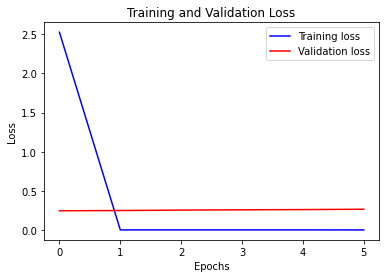

In [15]:
# Visualize the results
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



In [16]:
train_df

,guide_open,running_speed,pump101_speed,pump102_speed,discharge_rate,head_gross
157286,-1.113027,0.371962,-1.107841,-1.047744,-1.089484,0.719184
157296,-1.109955,0.371234,-1.103919,-1.049690,-1.091468,1.078675
157306,-1.109955,0.371962,-1.099997,-1.051635,-1.093453,1.129963
157316,-1.112259,0.371962,-1.096075,-1.053580,-1.091468,0.565162
157326,-1.113027,0.371234,-1.098036,-1.059416,-1.088985,0.000360
...,...,...,...,...,...,...
629096,-1.652592,-2.833099,-1.713793,-1.689699,-1.935028,0.257117
629106,-1.651824,-2.833099,-1.705949,-1.693589,-1.933043,0.359694
629116,-1.643759,-2.833099,-1.702027,-1.689699,-1.932046,0.359694
629126,-1.648752,-2.833099,-1.696144,-1.687754,-1.933043,0.308405


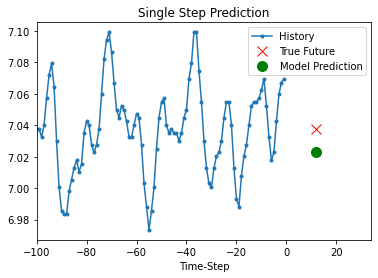

In [15]:
# Prediciton
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(1):
    show_plot(
        [x[0][:, 5].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )


## 2, Another way to provide dataset to Keras model

Please refer to the following link:[machinecurve](https://www.machinecurve.com/index.php/2020/04/05/how-to-find-the-value-for-keras-input_shape-input_dim/).